
--- Version 1 Started ---
Epoch 1: Acc 44.44%
Epoch 2: Acc 70.03%
Epoch 3: Acc 90.57%
Epoch 4: Acc 93.60%
Epoch 5: Acc 96.97%
Epoch 6: Acc 98.99%
Epoch 7: Acc 100.00%
Epoch 8: Acc 99.66%
Epoch 9: Acc 99.66%
Epoch 10: Acc 99.33%

--- Version 2 Started ---
Epoch 1: Acc 36.36%
Epoch 2: Acc 47.47%
Epoch 3: Acc 61.62%
Epoch 4: Acc 71.72%
Epoch 5: Acc 74.07%
Epoch 6: Acc 80.47%
Epoch 7: Acc 87.21%
Epoch 8: Acc 87.21%
Epoch 9: Acc 94.28%
Epoch 10: Acc 95.96%


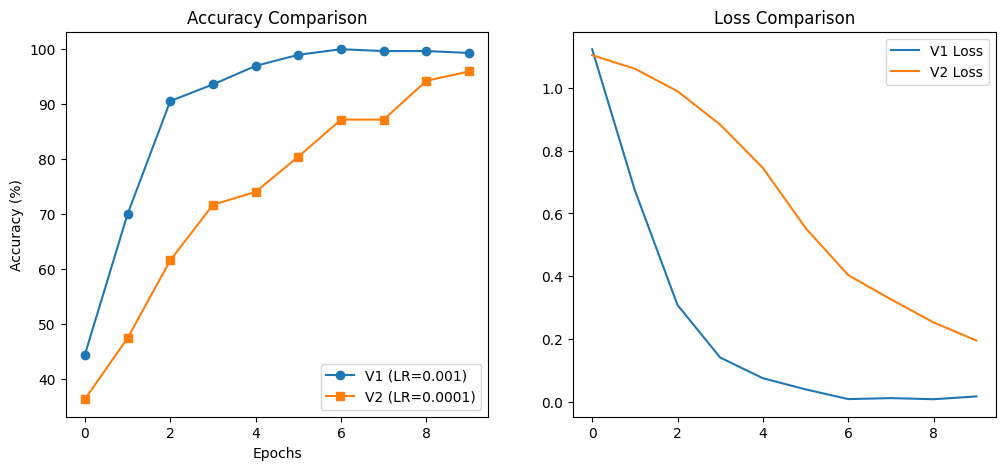


Final Accuracies:
Version 1: 99.33%
Version 2: 95.96%


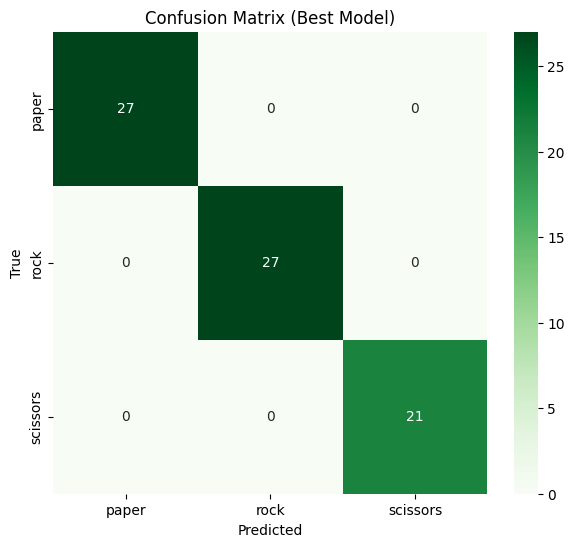

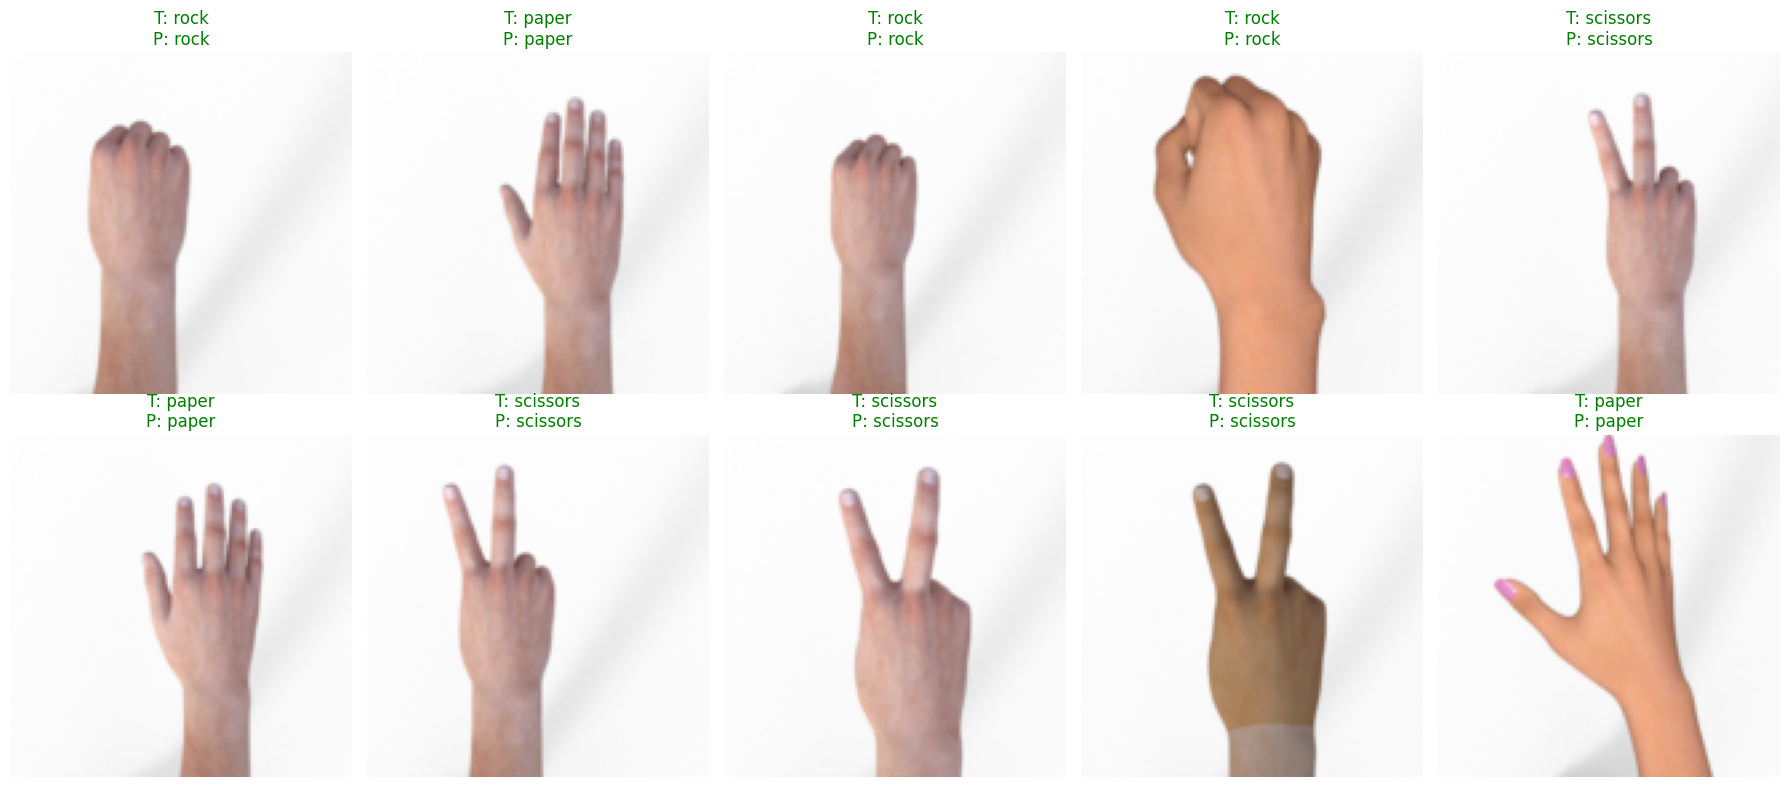

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns


SEED = 20240306  
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

found_path = ""
for root, dirs, files in os.walk('/kaggle/input'):
    if 'rock' in dirs and 'paper' in dirs:
        found_path = root
        break

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_dataset = datasets.ImageFolder(root=found_path, transform=transform)


valid_classes = ['paper', 'rock', 'scissors'] 
indices = [i for i, (_, label) in enumerate(full_dataset.samples) 
           if full_dataset.classes[label] in valid_classes]

class CleanSubset(torch.utils.data.Dataset):
    def __init__(self, subset):
        self.subset = subset
    def __getitem__(self, index):
        x, y = self.subset[index]
        label_name = full_dataset.classes[y]
        new_label = valid_classes.index(label_name)
        return x, new_label
    def __len__(self):
        return len(self.subset)

clean_dataset = CleanSubset(Subset(full_dataset, indices))
train_size = int(0.8 * len(clean_dataset))
train_data, test_data = random_split(clean_dataset, [train_size, len(clean_dataset)-train_size])


class RPSModel(nn.Module):
    def __init__(self, dropout_p=0.5):
        super(RPSModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(128, 3)
        )
    def forward(self, x):
        return self.classifier(self.features(x))


def run_train(lr, bs, dr, name):
    loader = DataLoader(train_data, batch_size=bs, shuffle=True)
    model = RPSModel(dropout_p=dr).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    history = {'loss': [], 'acc': []}
    print(f"\n--- {name} Started ---")
    for epoch in range(10):
        model.train()
        correct, total, loss_val = 0, 0, 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            loss_val += loss.item()
            _, pred = out.max(1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)
        acc = 100. * correct / total
        history['acc'].append(acc)
        history['loss'].append(loss_val/len(loader))
        print(f"Epoch {epoch+1}: Acc {acc:.2f}%")
    return model, history


model_v1, hist_v1 = run_train(0.001, 32, 0.5, "Version 1")
model_v2, hist_v2 = run_train(0.0001, 32, 0.5, "Version 2")


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist_v1['acc'], label='V1 (LR=0.001)', marker='o')
plt.plot(hist_v2['acc'], label='V2 (LR=0.0001)', marker='s')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_v1['loss'], label='V1 Loss')
plt.plot(hist_v2['loss'], label='V2 Loss')
plt.title('Loss Comparison')
plt.legend()
plt.show()


print(f"\nFinal Accuracies:\nVersion 1: {hist_v1['acc'][-1]:.2f}%\nVersion 2: {hist_v2['acc'][-1]:.2f}%")


all_preds, all_labels = [], []
model_v1.eval()
with torch.no_grad():
    for imgs, lbls in DataLoader(test_data, batch_size=32):
        out = model_v1(imgs.to(device))
        _, prd = out.max(1)
        all_preds.extend(prd.cpu().numpy())
        all_labels.extend(lbls.numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=valid_classes, yticklabels=valid_classes, cmap='Greens')
plt.title('Confusion Matrix (Best Model)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


test_loader = DataLoader(test_data, batch_size=10, shuffle=True)
images, labels = next(iter(test_loader))
model_v1.eval()
with torch.no_grad():
    out = model_v1(images.to(device))
    _, preds = out.max(1)

plt.figure(figsize=(18, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5
    plt.imshow(img.clip(0, 1))
    color = 'green' if preds[i] == labels[i] else 'red'
    plt.title(f"T: {valid_classes[labels[i]]}\nP: {valid_classes[preds[i]]}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()